In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import sys
sys.path.append("../../../../../src")

import nanonets_utils

from scipy import signal

plt.style.use(["science","bright"])

In [21]:
def load_time_series(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:]
            n       +=  1
    return dic

In [29]:
param   = "amplitude"
N_th    = 8
n_p_t   = 1
N_p     = 11
t_step  = 1e-7
folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/{param}/"
data    = load_time_series(folder, N_th, n_p_t, N_p)
t_vals  = np.arange(len(data[0]))*1e-7*1e6

In [2]:
N_threads   = 8
samples_p_t = 1
N_samples   = samples_p_t*N_threads
N_voltages  = 1000
n_eq        = 1

def load_data(N_p, folder):
    arr1        = np.zeros(shape=(N_voltages-n_eq,N_samples))
    arr2        = np.zeros(shape=(N_voltages-n_eq,N_samples))
    time_step   = 1e-7
    t_vals      = np.arange(N_voltages-n_eq)*time_step*1e6
    rel_path    = f"../../../../../../data/2_funding_period/potential/magic_cable/{folder}/"
    x_vals      = pd.read_csv(f"{rel_path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_0_0.csv").loc[(n_eq-1):,'E0'].values*1000
    n           = 0

    for i in range(N_threads):
        for j in range(N_samples//N_threads):
            df          =   pd.read_csv(f"{rel_path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            arr1[:,n]   =   df.loc[(n_eq-1):,'Current'].values*1000
            arr2[:,n]   =   df.loc[(n_eq-1):,'Error'].values*1000
            n           +=  1
    
    return t_vals, x_vals, arr1, arr2, df

def return_best_fit(y_real_arr, y_target):
    y_target    = scale(y_target)
    rmse        = []

    for i in range(y_real_arr.shape[1]):
        y_real  = y_real_arr[:,i].copy()
        y_real  = scale(y_real)
        rmse.append(np.sqrt(np.sum((y_real-y_target)**2)))

    return np.argsort(rmse), rmse

## Sample

In [4]:
folder                          = 'amplitude'
t_vals, x_vals, arr1, arr2, df  = load_data(11, folder)

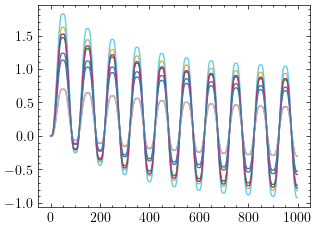

In [16]:
plt.plot(arr1)

IndexError: index 8 is out of bounds for axis 1 with size 8

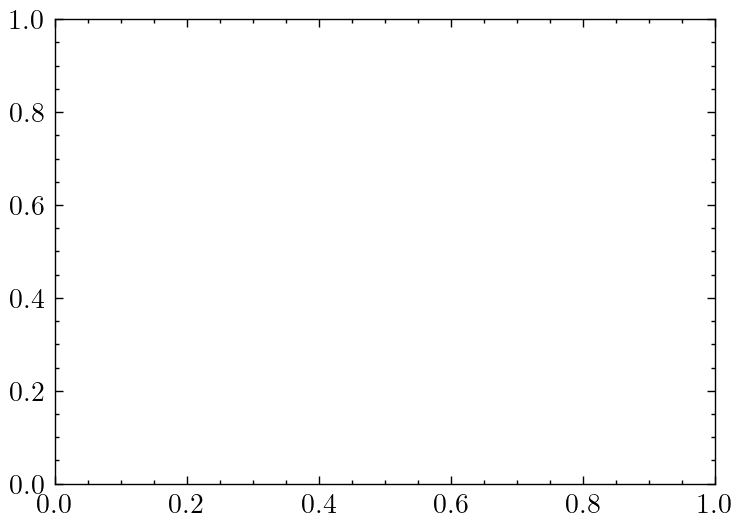

In [14]:
idx = 8

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, arr1[:,idx])
ax.fill_between(t_vals, arr1[:,idx]-arr2[:,idx], arr1[:,idx]+arr2[:,idx], color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu s$]')
ax.set_ylabel('$U_7$ [$mV$]')

ax  = fig.add_subplot(1,2,2)
ax.plot(x_vals, arr1[:,idx])
ax.set_xlabel('$U_1$ [$mV$]')
ax.set_ylabel('$U_7$ [$mV$]')

## Train

In [334]:
y_target        = 10*signal.square(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1, 0.5)
fit_order, rmse = return_best_fit(y_real_arr=arr1, y_target=y_target)
best_idx        = fit_order[1]

Text(0.5, 0, '$t$ [$\\mu s$]')

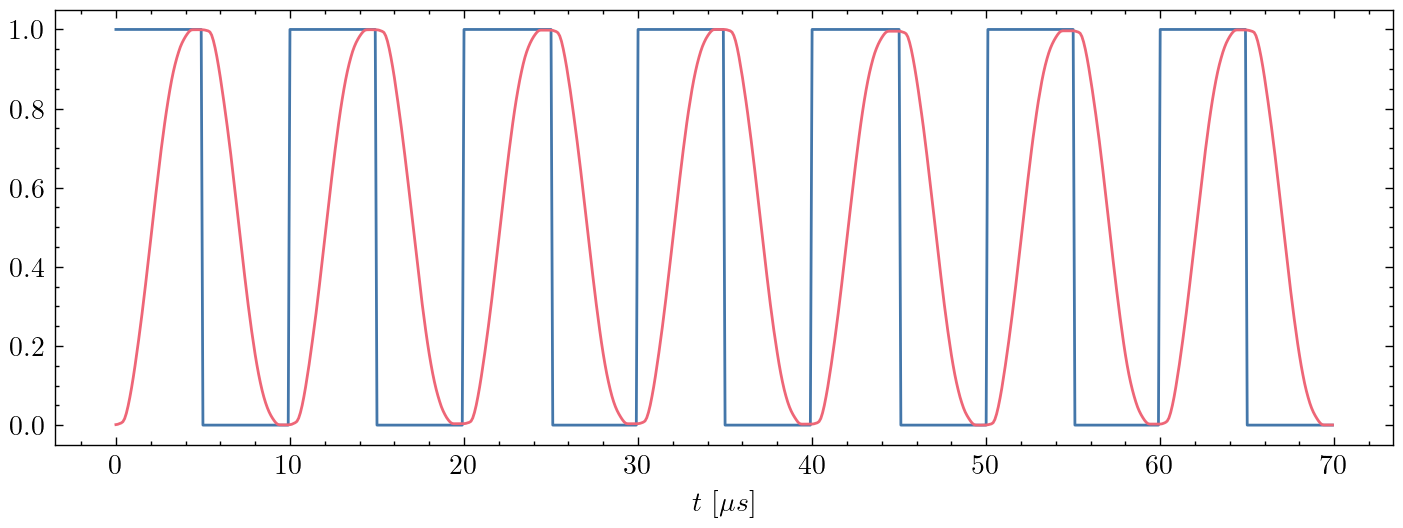

In [335]:
y_1 = scale(y_target)
y_2 = scale(arr1[:,best_idx])

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot()
ax.plot(t_vals, y_1)
ax.plot(t_vals, y_2)
ax.set_xlabel('$t$ [$\mu s$]')

## Shannon Rank

In [336]:
def shannon_rank(state : np.array):

    U, S, Vt    = np.linalg.svd(state)
    p           = S / np.sum(S)
    rank        = np.exp(-np.sum(p*np.log(p)))

    return rank